In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [ ]:
# Read the CSV file as a DataFrame
data = pd.read_csv(list(uploaded.keys())[0])
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Separate features and labels
X = data.drop('label', axis=1).values  # Pixel values (m x 784)
Y = data['label'].values  # Labels (m,)

# Normalize pixel values to [0, 1]
X = X / 255.0

# Shuffle the dataset
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
Y = Y[indices]

# Split into train and dev sets
m, n = X.shape
data_dev = X[0:1000].T  # 784 x 1000
Y_dev = Y[0:1000]
X_dev = data_dev

data_train = X[1000:m].T  # 784 x (m-1000)
Y_train = Y[1000:]
X_train = data_train

In [ ]:
X_train[:, 0].shape

(784,)

In [ ]:
def init_params():
    # Initialize parameters: 784 -> 256 -> 128 -> 10
    W1 = np.random.randn(256, 784) * np.sqrt(2.0 / 784)  # He initialization
    b1 = np.zeros((256, 1))
    W2 = np.random.randn(128, 256) * np.sqrt(2.0 / 256)
    b2 = np.zeros((128, 1))
    W3 = np.random.randn(10, 128) * np.sqrt(2.0 / 128)
    b3 = np.zeros((10, 1))
    return W1, b1, W2, b2, W3, b3

def ReLu(Z):
    return np.maximum(Z, 0)

def dropout(A, keep_prob=0.7):
    D = np.random.rand(*A.shape) < keep_prob
    A *= D
    A /= keep_prob  # Scale to maintain expected value
    return A, D

def softmax(Z):
    # Numerically stable softmax
    Z_max = np.max(Z, axis=0, keepdims=True)
    exp_Z = np.exp(Z - Z_max)
    A = exp_Z / np.sum(exp_Z, axis=0, keepdims=True)
    return A

def forward_propagation(W1, b1, W2, b2, W3, b3, X, training=True):
    Z1 = W1.dot(X) + b1
    A1 = ReLu(Z1)
    if training:
        A1, D1 = dropout(A1, keep_prob=0.7)
    else:
        A1, D1 = A1, None
    Z2 = W2.dot(A1) + b2
    A2 = ReLu(Z2)
    if training:
        A2, D2 = dropout(A2, keep_prob=0.7)
    else:
        A2, D2 = A2, None
    Z3 = W3.dot(A2) + b3
    A3 = softmax(Z3)
    return Z1, A1, D1, Z2, A2, D2, Z3, A3

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T  # Shape: (10, m)
    return one_hot_Y

def derivate_ReLU(Z):
    return Z > 0

def back_propagation(Z1, A1, D1, Z2, A2, D2, Z3, A3, W1, W2, W3, X, Y, lambda_reg=0.01):
    m = Y.size
    one_hot_Y = one_hot(Y)
    dZ3 = A3 - one_hot_Y
    dW3 = (1 / m) * dZ3.dot(A2.T) + (lambda_reg / m) * W3  # L2 regularization
    db3 = (1 / m) * np.sum(dZ3, axis=1, keepdims=True)
    dA2 = W3.T.dot(dZ3)
    dA2 *= D2 / 0.7 if D2 is not None else 1
    dZ2 = dA2 * derivate_ReLU(Z2)
    dW2 = (1 / m) * dZ2.dot(A1.T) + (lambda_reg / m) * W2
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    dA1 = W2.T.dot(dZ2)
    dA1 *= D1 / 0.7 if D1 is not None else 1
    dZ1 = dA1 * derivate_ReLU(Z1)
    dW1 = (1 / m) * dZ1.dot(X.T) + (lambda_reg / m) * W1
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    return dW1, db1, dW2, db2, dW3, db3

def update_params_adam(params, grads, v, s, t, alpha=0.002, beta1=0.9, beta2=0.999, epsilon=1e-8):
    W1, b1, W2, b2, W3, b3 = params
    dW1, db1, dW2, db2, dW3, db3 = grads
    v_W1, v_b1, v_W2, v_b2, v_W3, v_b3 = v
    s_W1, s_b1, s_W2, s_b2, s_W3, s_b3 = s

    # Update biased first moment estimate
    v_W1 = beta1 * v_W1 + (1 - beta1) * dW1
    v_b1 = beta1 * v_b1 + (1 - beta1) * db1
    v_W2 = beta1 * v_W2 + (1 - beta1) * dW2
    v_b2 = beta1 * v_b2 + (1 - beta1) * db2
    v_W3 = beta1 * v_W3 + (1 - beta1) * dW3
    v_b3 = beta1 * v_b3 + (1 - beta1) * db3

    # Update biased second moment estimate
    s_W1 = beta2 * s_W1 + (1 - beta2) * (dW1 ** 2)
    s_b1 = beta2 * s_b1 + (1 - beta2) * (db1 ** 2)
    s_W2 = beta2 * s_W2 + (1 - beta2) * (dW2 ** 2)
    s_b2 = beta2 * s_b2 + (1 - beta2) * (db2 ** 2)
    s_W3 = beta2 * s_W3 + (1 - beta2) * (dW3 ** 2)
    s_b3 = beta2 * s_b3 + (1 - beta2) * (db3 ** 2)

    # Bias correction
    v_W1_corr = v_W1 / (1 - beta1 ** t)
    v_b1_corr = v_b1 / (1 - beta1 ** t)
    v_W2_corr = v_W2 / (1 - beta1 ** t)
    v_b2_corr = v_b2 / (1 - beta1 ** t)
    v_W3_corr = v_W3 / (1 - beta1 ** t)
    v_b3_corr = v_b3 / (1 - beta1 ** t)
    s_W1_corr = s_W1 / (1 - beta2 ** t)
    s_b1_corr = s_b1 / (1 - beta2 ** t)
    s_W2_corr = s_W2 / (1 - beta2 ** t)
    s_b2_corr = s_b2 / (1 - beta2 ** t)
    s_W3_corr = s_W3 / (1 - beta2 ** t)
    s_b3_corr = s_b3 / (1 - beta2 ** t)

    # Update parameters
    W1 -= alpha * v_W1_corr / (np.sqrt(s_W1_corr) + epsilon)
    b1 -= alpha * v_b1_corr / (np.sqrt(s_b1_corr) + epsilon)
    W2 -= alpha * v_W2_corr / (np.sqrt(s_W2_corr) + epsilon)
    b2 -= alpha * v_b2_corr / (np.sqrt(s_b2_corr) + epsilon)
    W3 -= alpha * v_W3_corr / (np.sqrt(s_W3_corr) + epsilon)
    b3 -= alpha * v_b3_corr / (np.sqrt(s_b3_corr) + epsilon)

    return [W1, b1, W2, b2, W3, b3], [v_W1, v_b1, v_W2, v_b2, v_W3, v_b3], [s_W1, s_b1, s_W2, s_b2, s_W3, s_b3]

In [ ]:
def get_predictions(A3):
    return np.argmax(A3, 0)

def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

def gradien_descent(X, Y, iterations, alpha=0.002, batch_size=64, lambda_reg=0.01):
    W1, b1, W2, b2, W3, b3 = init_params()
    v = [np.zeros_like(W1), np.zeros_like(b1), np.zeros_like(W2), np.zeros_like(b2), np.zeros_like(W3), np.zeros_like(b3)]
    s = [np.zeros_like(W1), np.zeros_like(b1), np.zeros_like(W2), np.zeros_like(b2), np.zeros_like(W3), np.zeros_like(b3)]
    m = X.shape[1]
    train_accuracies = []
    dev_accuracies = []

    for i in range(iterations):
        # Learning rate decay
        lr = alpha * (1.0 / (1.0 + 0.002 * i))
        # Mini-batch gradient descent
        for start in range(0, m, batch_size):
            end = min(start + batch_size, m)
            X_batch = X[:, start:end]
            Y_batch = Y[start:end]
            Z1, A1, D1, Z2, A2, D2, Z3, A3 = forward_propagation(W1, b1, W2, b2, W3, b3, X_batch, training=True)
            dW1, db1, dW2, db2, dW3, db3 = back_propagation(Z1, A1, D1, Z2, A2, D2, Z3, A3, W1, W2, W3, X_batch, Y_batch, lambda_reg)
            [W1, b1, W2, b2, W3, b3], v, s = update_params_adam(
                [W1, b1, W2, b2, W3, b3], [dW1, db1, dW2, db2, dW3, db3], v, s, i + 1, alpha=lr
            )
        if i % 20 == 0:
            # Training accuracy
            _, _, _, _, _, _, _, A3 = forward_propagation(W1, b1, W2, b2, W3, b3, X, training=False)
            predictions = get_predictions(A3)
            train_acc = get_accuracy(predictions, Y)
            train_accuracies.append(train_acc)
            # Dev accuracy
            _, _, _, _, _, _, _, A3_dev = forward_propagation(W1, b1, W2, b2, W3, b3, X_dev, training=False)
            predictions_dev = get_predictions(A3_dev)
            dev_acc = get_accuracy(predictions_dev, Y_dev)
            dev_accuracies.append(dev_acc)
            print(f"Iteration: {i}, Train Accuracy: {train_acc:.4f}, Dev Accuracy: {dev_acc:.4f}")
            # Early stopping if dev accuracy plateaus
            if i > 100 and dev_accuracies[-1] < dev_accuracies[-2] and dev_accuracies[-1] < 0.95:
                print("Early stopping due to dev accuracy plateau.")
                break
    # Plot accuracies
    plt.plot(range(0, len(train_accuracies) * 20, 20), train_accuracies, label='Train Accuracy')
    plt.plot(range(0, len(dev_accuracies) * 20, 20), dev_accuracies, label='Dev Accuracy')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.title('Training and Dev Accuracy Over Iterations')
    plt.legend()
    plt.show()
    return W1, b1, W2, b2, W3, b3

Iteration: 0, Train Accuracy: 0.9655, Dev Accuracy: 0.9620
Iteration: 20, Train Accuracy: 0.9971, Dev Accuracy: 0.9780
Iteration: 40, Train Accuracy: 0.9987, Dev Accuracy: 0.9740
Iteration: 60, Train Accuracy: 0.9986, Dev Accuracy: 0.9770
Iteration: 80, Train Accuracy: 0.9991, Dev Accuracy: 0.9760
Iteration: 100, Train Accuracy: 0.9987, Dev Accuracy: 0.9790
Iteration: 120, Train Accuracy: 0.9988, Dev Accuracy: 0.9810
Iteration: 140, Train Accuracy: 0.9988, Dev Accuracy: 0.9710
Iteration: 160, Train Accuracy: 0.9987, Dev Accuracy: 0.9770
Iteration: 180, Train Accuracy: 0.9991, Dev Accuracy: 0.9790


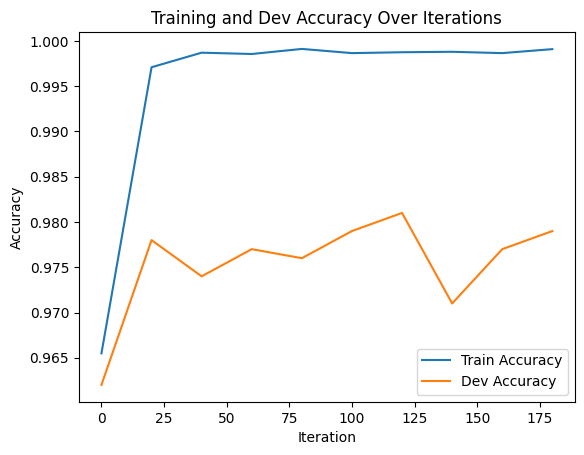

In [ ]:
# Train the model
W1, b1, W2, b2, W3, b3 = gradien_descent(X_train, Y_train, iterations=200, alpha=0.002, batch_size=64, lambda_reg=0.01)

Final Dev set accuracy: 0.9790


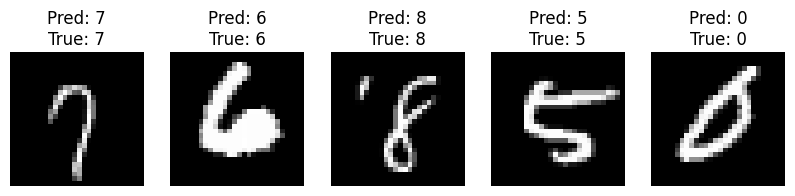

In [ ]:
# Evaluate on dev set
_, _, _, _, _, _, _, A3_dev = forward_propagation(W1, b1, W2, b2, W3, b3, X_dev, training=False)
predictions_dev = get_predictions(A3_dev)
accuracy_dev = get_accuracy(predictions_dev, Y_dev)
print(f"Final Dev set accuracy: {accuracy_dev:.4f}")

# Visualize predictions
def plot_predictions(X, Y, predictions, num_images=5):
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(X[:, i].reshape(28, 28), cmap='gray')
        plt.title(f"Pred: {predictions[i]}\nTrue: {Y[i]}")
        plt.axis('off')
    plt.show()

plot_predictions(X_dev, Y_dev, predictions_dev)